In [5]:
import pandas as pd
import numpy as np
from re import T
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
id=0
data=pd.read_csv('/home/ebotian/MCM/tennis2.csv')

def pre_process(data):
    data = pd.get_dummies(data, columns=['winner_shot_type','serve_width','serve_depth','return_depth'])
    data = data.fillna(0)
    data = data.replace('AD', 50.0)
    grouped = dict(tuple(data.groupby(data['match_id'].ne(data['match_id'].shift()).cumsum())))
    subdata = {df['match_id'].iloc[0]: df for _, df in grouped.items()}
    match = pd.DataFrame(data.iloc[:, 0].drop_duplicates()).iloc[:,0].tolist()
    return subdata,match
subdata,match=pre_process(data)

def process_all_ids(subdata):
    features={}
    target={}
    for id in range(len(match)):
        target[match[id]]=pd.DataFrame(subdata[match[id]]["point_victor"])
        subdata[match[id]]['elapsed_time'] = pd.to_timedelta(subdata[match[id]]['elapsed_time'])
        features[match[id]]=subdata[match[id]].drop(columns=["point_victor"]).iloc[:,4:]
        subdata[match[id]]=subdata[match[id]].drop(columns=["point_victor"])
    return target,features,subdata
target,features,subdata=process_all_ids(subdata)

def get_average_interval(id, subdata):
    subdata[match[id]]['time_diff'] = subdata[match[id]]['elapsed_time'].diff()
    lower_threshold = subdata[match[id]]['time_diff'].quantile(0.05)
    upper_threshold = subdata[match[id]]['time_diff'].quantile(0.95)
    filtered_diff = subdata[match[id]]['time_diff'][(subdata[match[id]]['time_diff'] > lower_threshold) & (subdata[match[id]]['time_diff'] < upper_threshold)]
    average_interval = filtered_diff.mean()
    return average_interval.total_seconds()

average_interval_time=[]
for id in range(len(match)):
    average_interval_time.append(get_average_interval(id, subdata))


X_train={}
X_test={}
y_train={}
y_test={}
for id in range(len(match)):
  X_train[match[id]], X_test[match[id]], y_train[match[id]], y_test[match[id]] = train_test_split(features[match[id]], target[match[id]], test_size=0.3, random_state=42)


classifier={}
X_test_scaled={}
for id in range(len(match)):
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train[match[id]].values)
  X_test_scaled[match[id]] = scaler.transform(X_test[match[id]].values)
  classifier[match[id]] = RandomForestClassifier(n_estimators=100, random_state=42)
  #classifier[match[id]].fit(X_train_scaled, y_train[match[id]].values.ravel())
  classifier[match[id]].fit(X_train_scaled, y_train[match[id]].values.ravel())


y_pred={}
for id in range(len(match)):
  y_pred[match[id]] = classifier[match[id]].predict(X_test_scaled[match[id]])


accuracy={}
importances={}
feature_importances={}
for id in range(len(match)):
  accuracy[match[id]] = accuracy_score(y_test[match[id]], y_pred[match[id]])
  importances[match[id]] = classifier[match[id]].feature_importances_
  feature_names = X_train[match[id]].columns
  feature_importances[match[id]] = pd.Series(importances[match[id]], index=feature_names).sort_values(ascending=False)

print(feature_importances[match[id]])
print(accuracy[match[id]])

p1_winner             0.158661
p2_unf_err            0.086478
p1_unf_err            0.064819
p2_net_pt_won         0.055926
speed_mph             0.047687
p2_distance_run       0.046856
p2_winner             0.040867
p1_distance_run       0.040248
rally_count           0.037611
p1_points_won         0.035951
point_no              0.032855
p1_net_pt_won         0.032487
server                0.031680
p2_points_won         0.029543
game_victor           0.026441
winner_shot_type_0    0.019804
game_no               0.019543
p1_games              0.017107
p1_score              0.016501
p2_score              0.014792
p2_games              0.013342
p2_net_pt             0.011076
winner_shot_type_F    0.009285
return_depth_ND       0.007351
p1_break_pt_missed    0.007268
serve_width_B         0.006989
set_no                0.006792
serve_depth_CTL       0.006514
return_depth_D        0.006414
serve_width_BW        0.005985
serve_width_C         0.005929
p2_sets               0.005866
serve_de

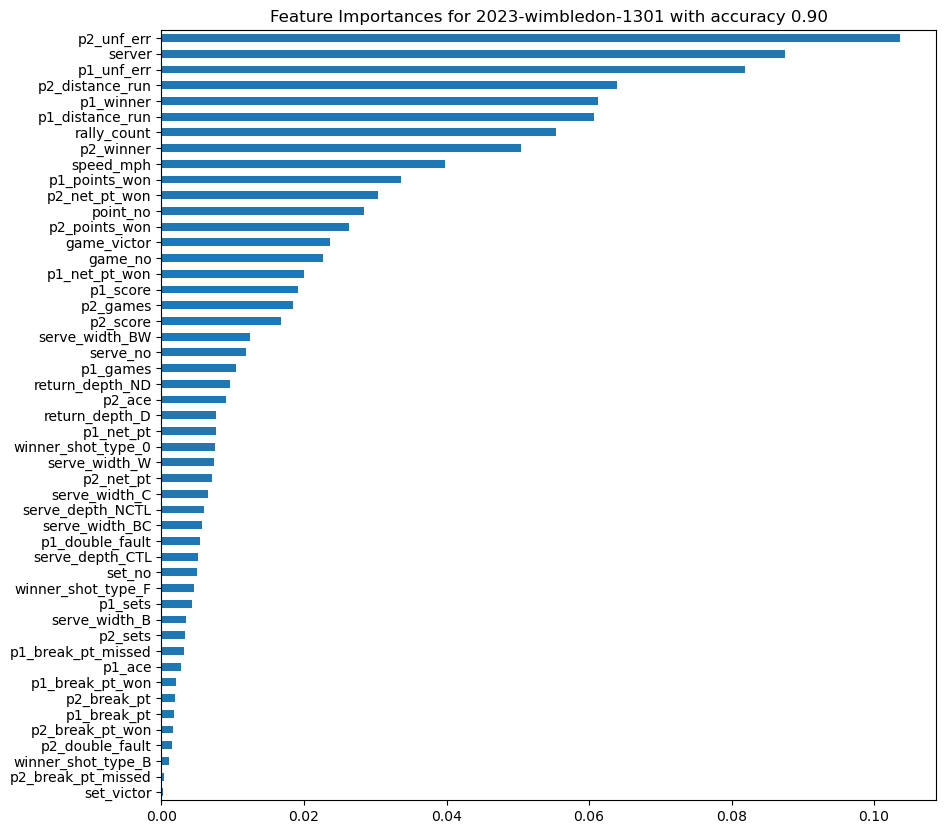

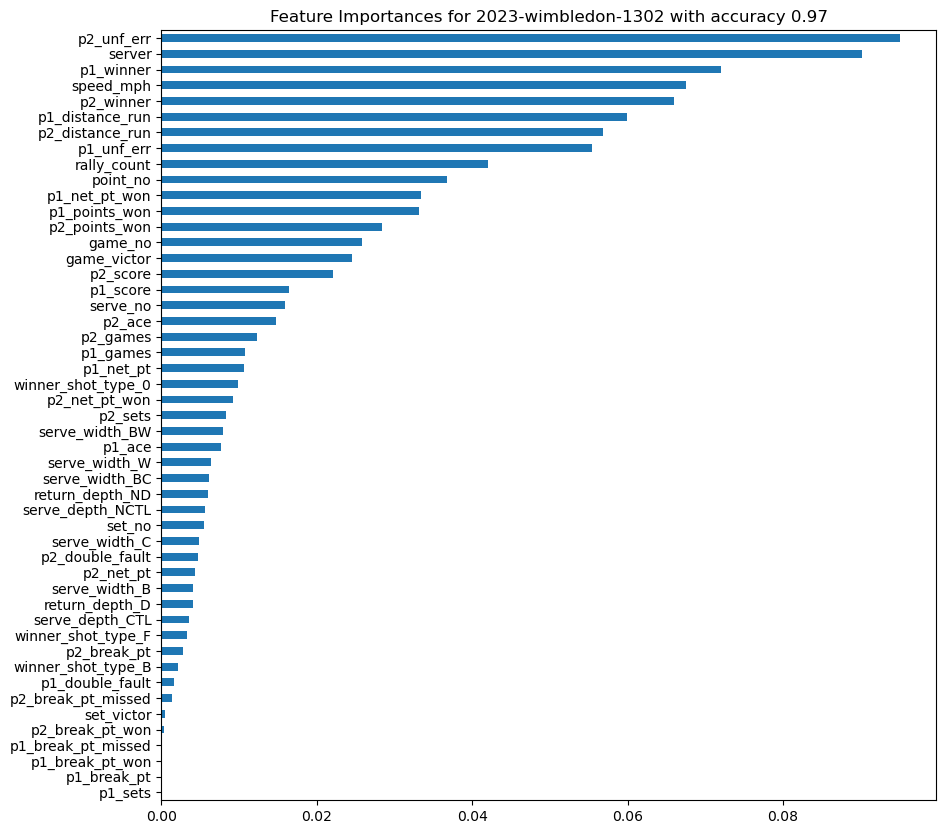

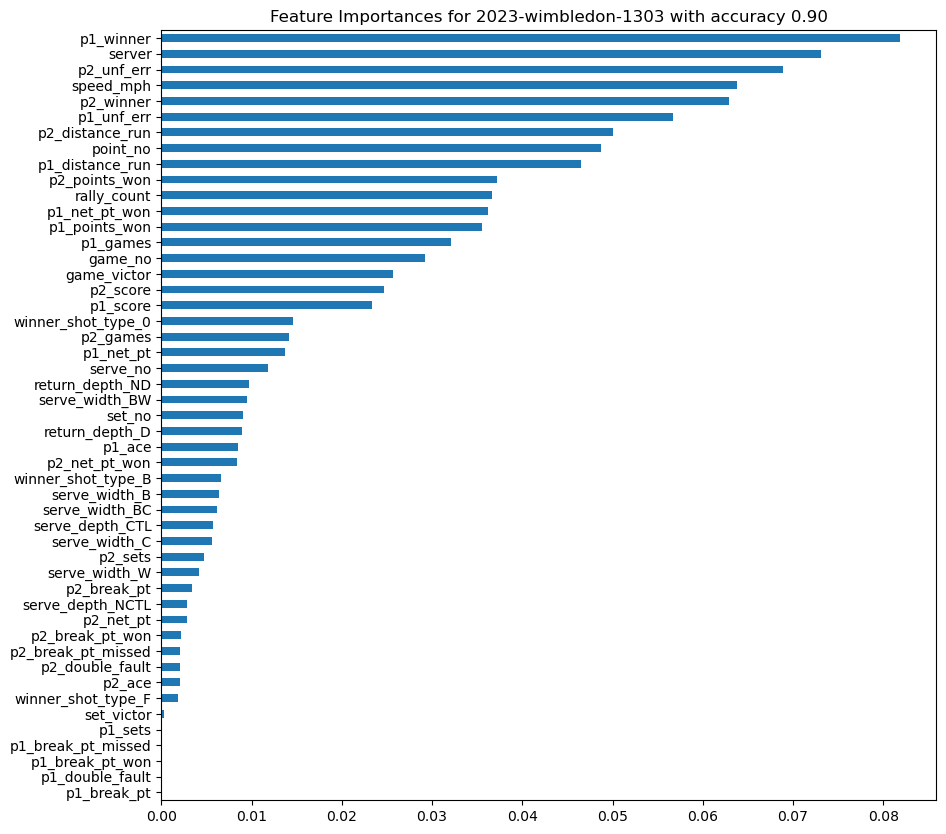

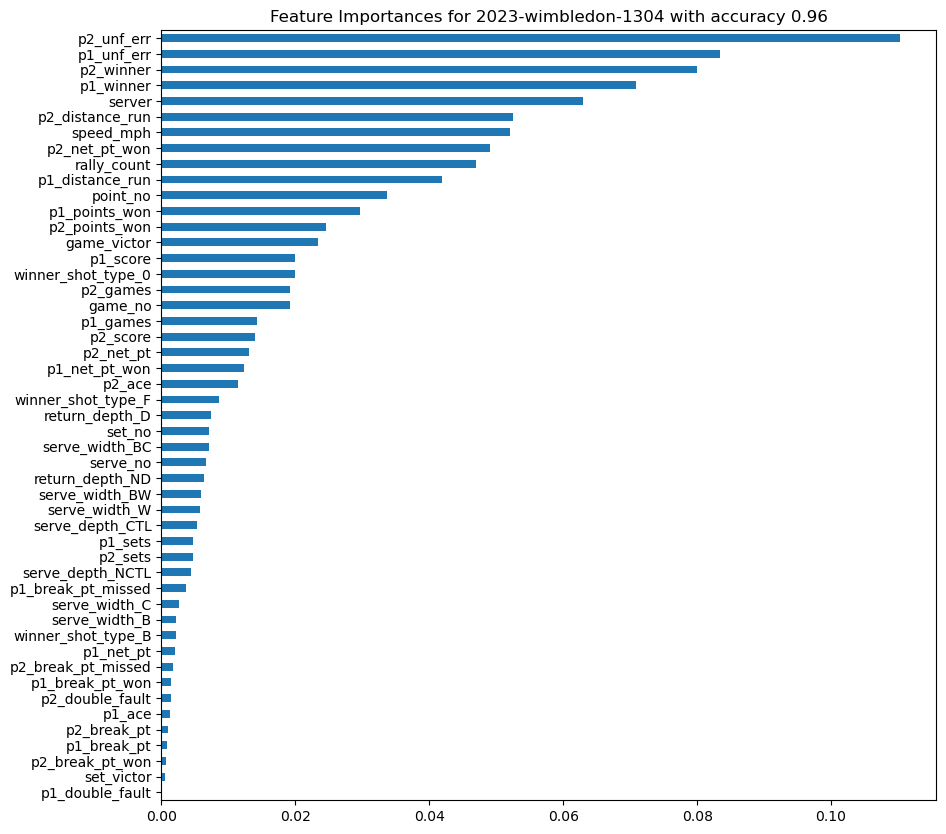

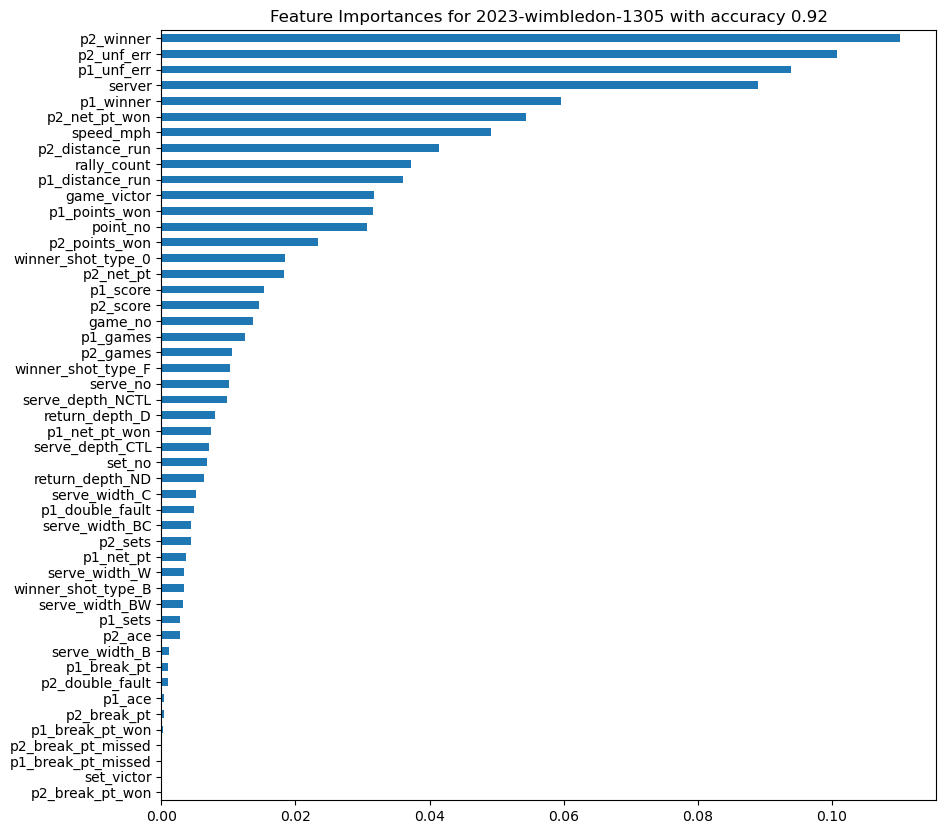

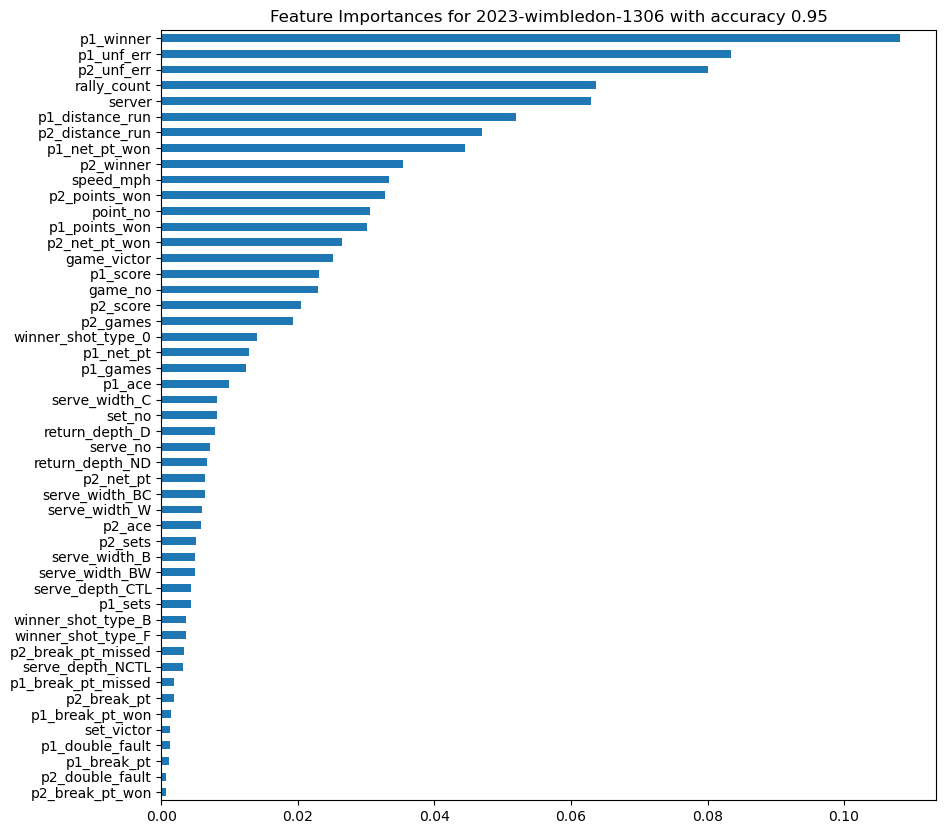

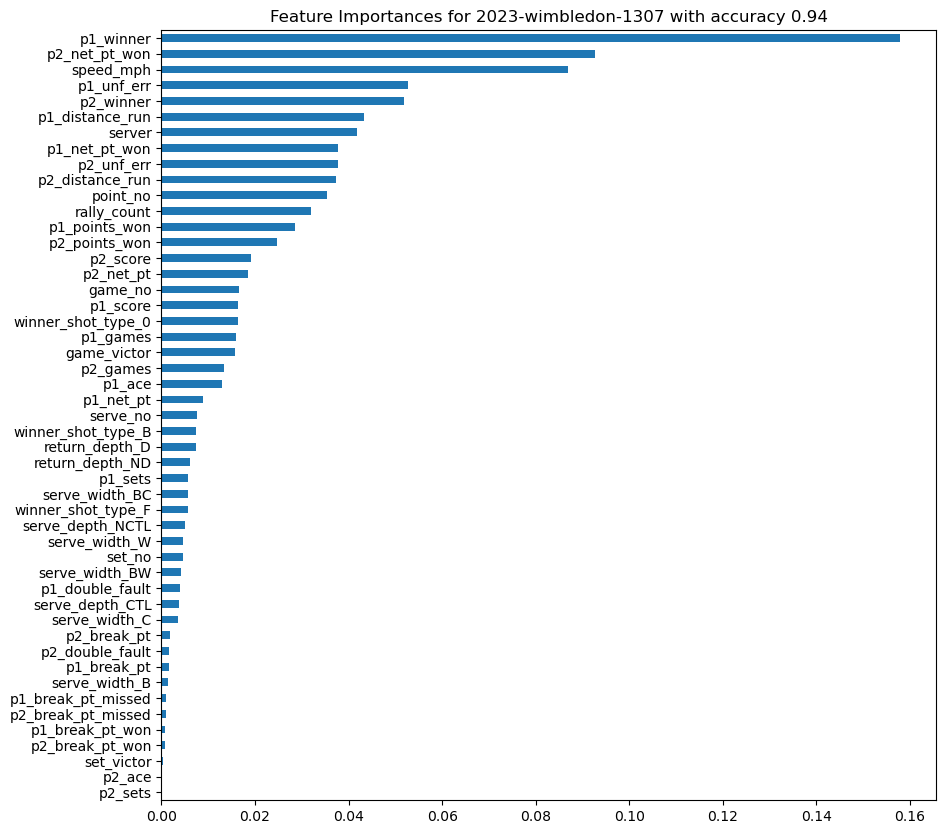

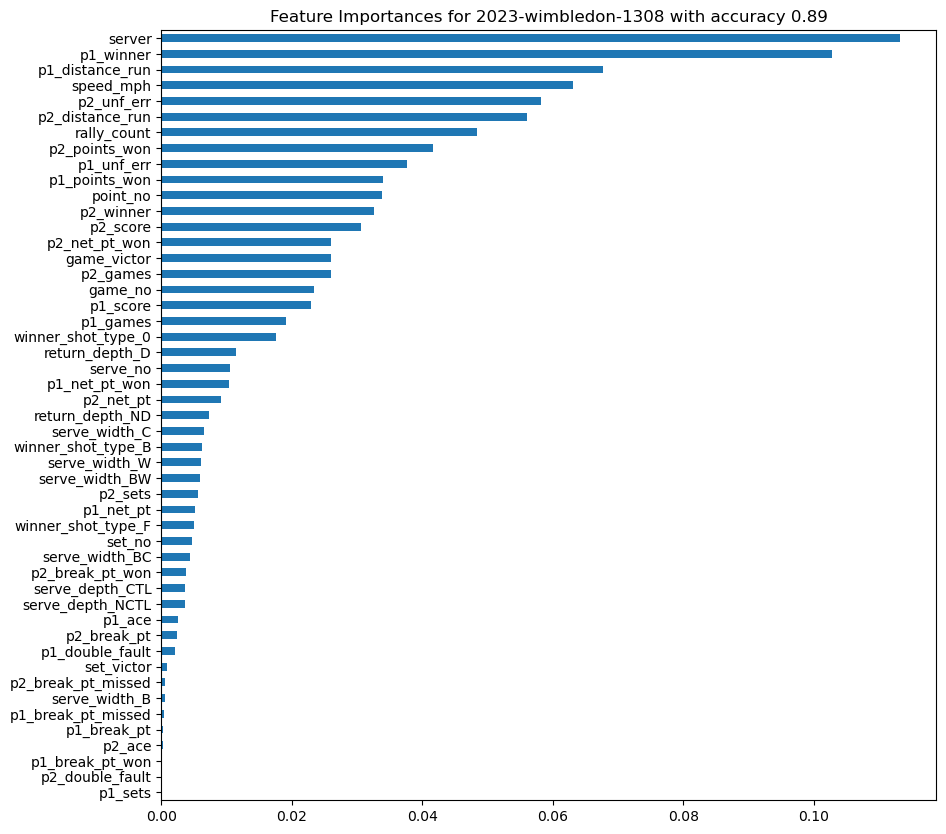

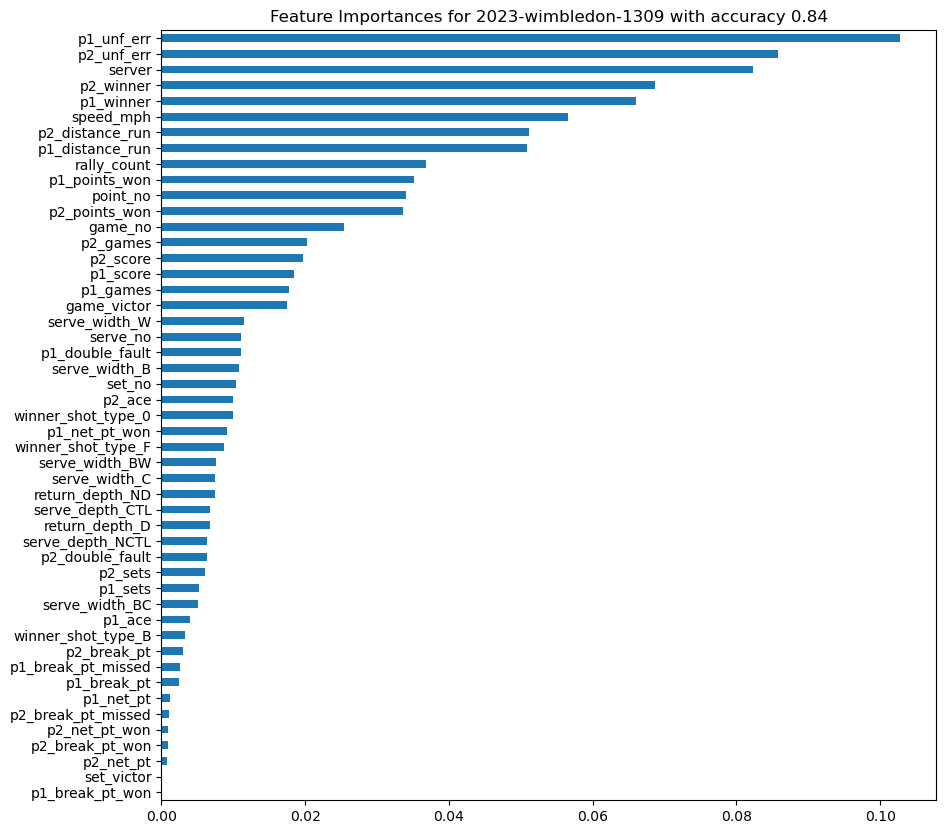

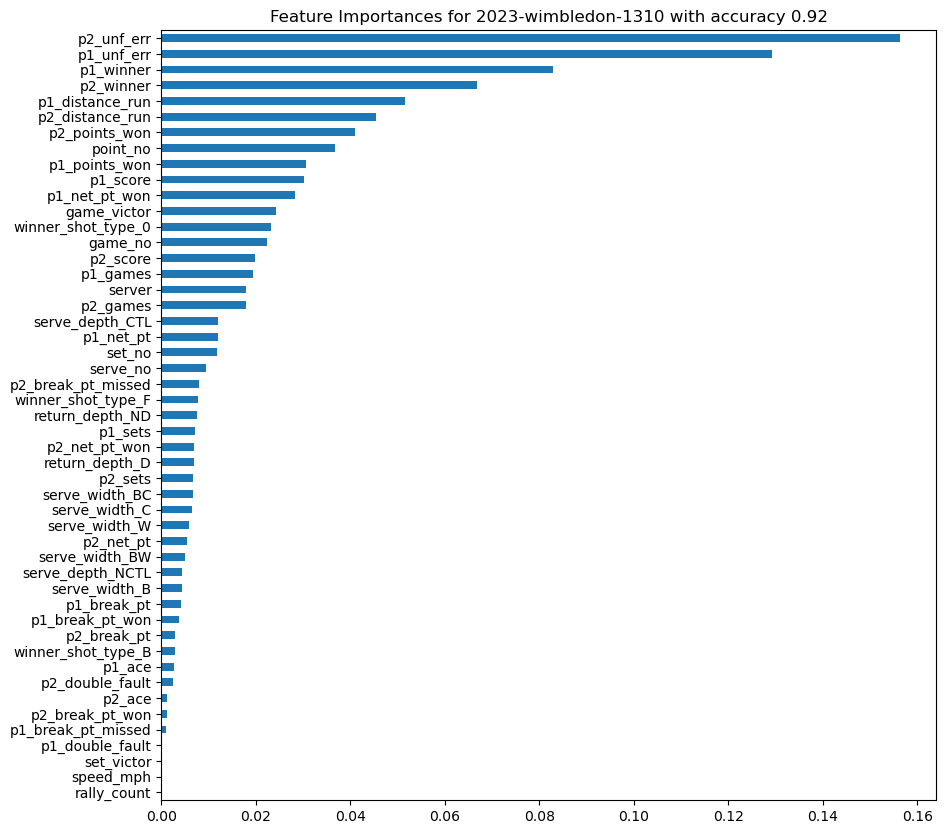

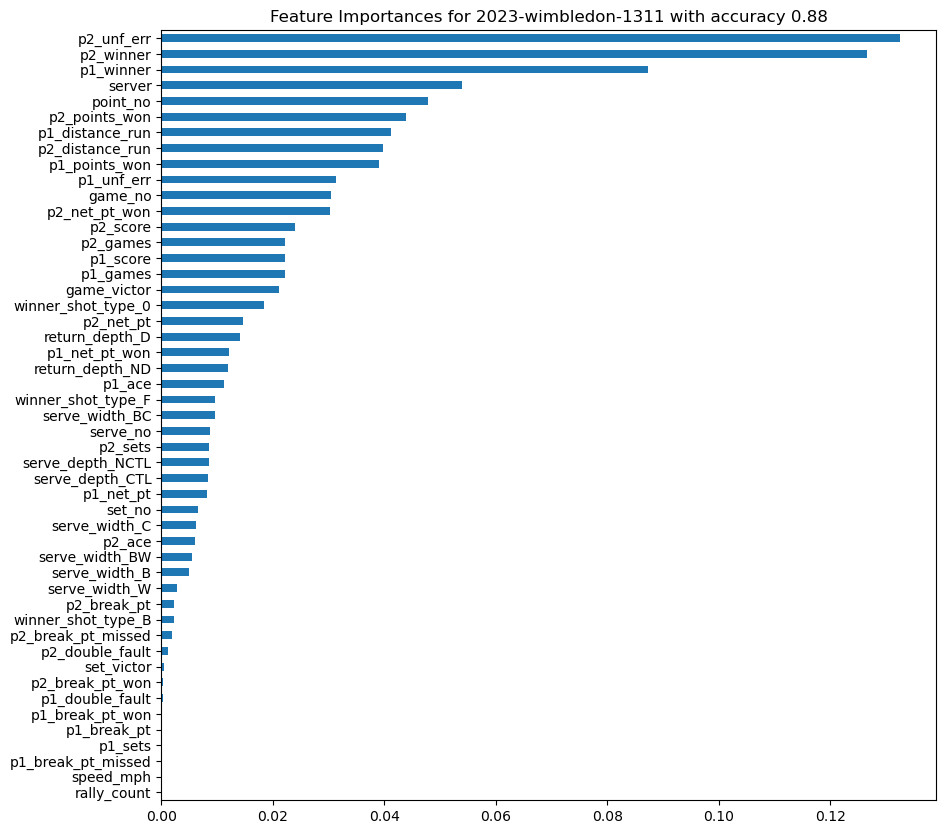

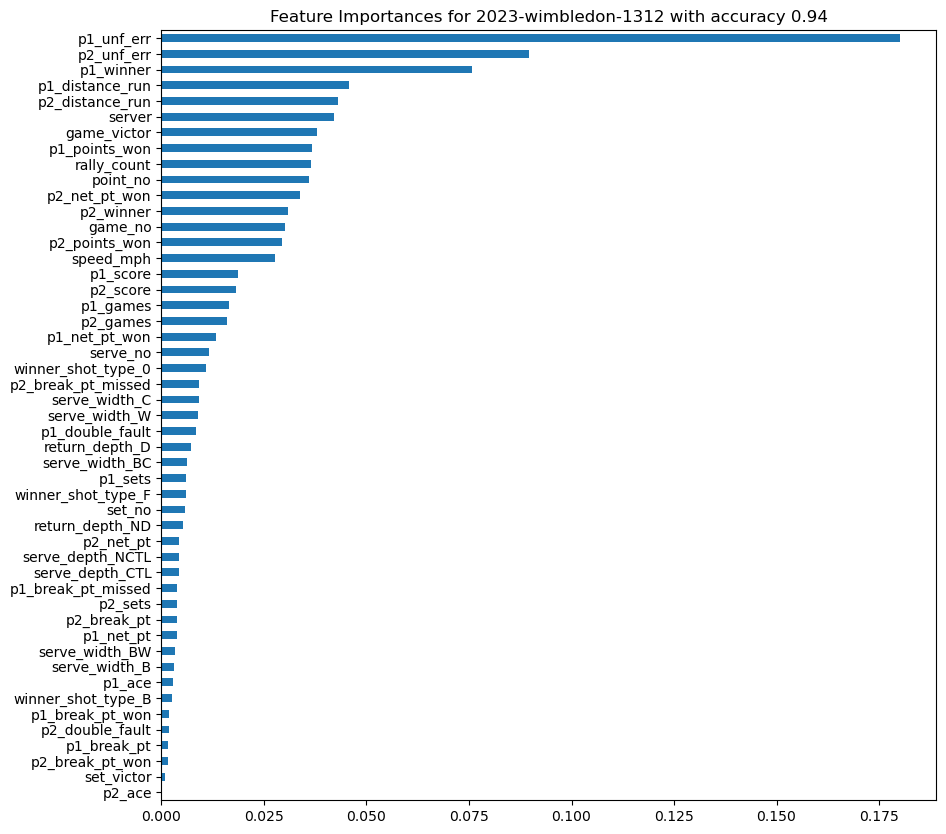

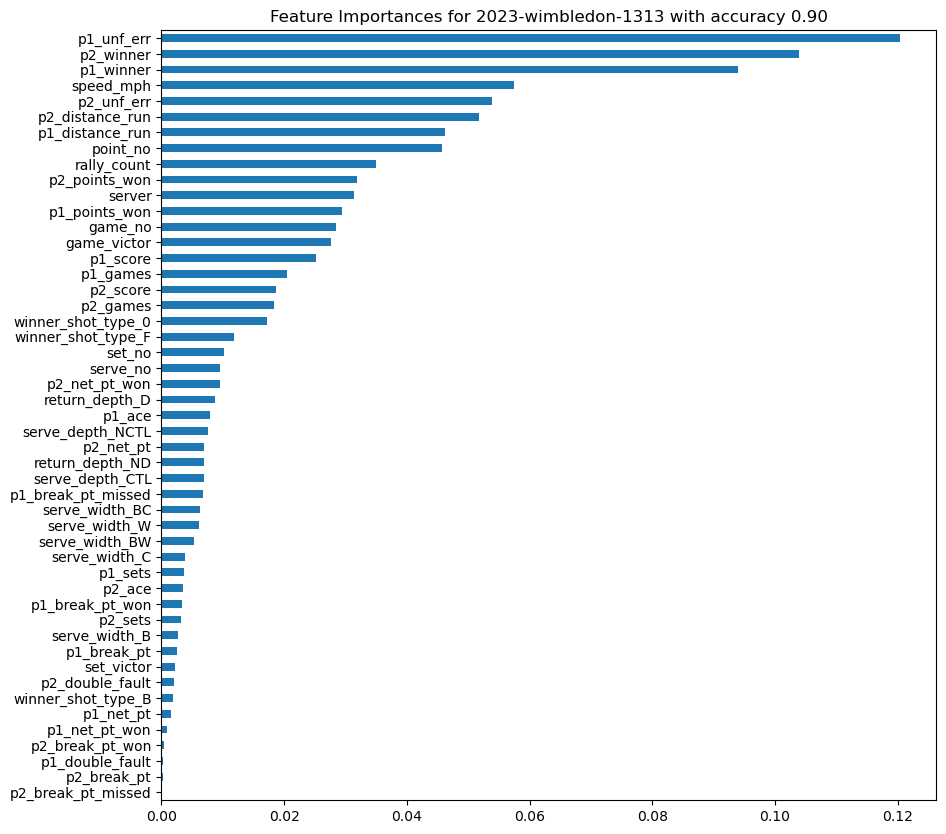

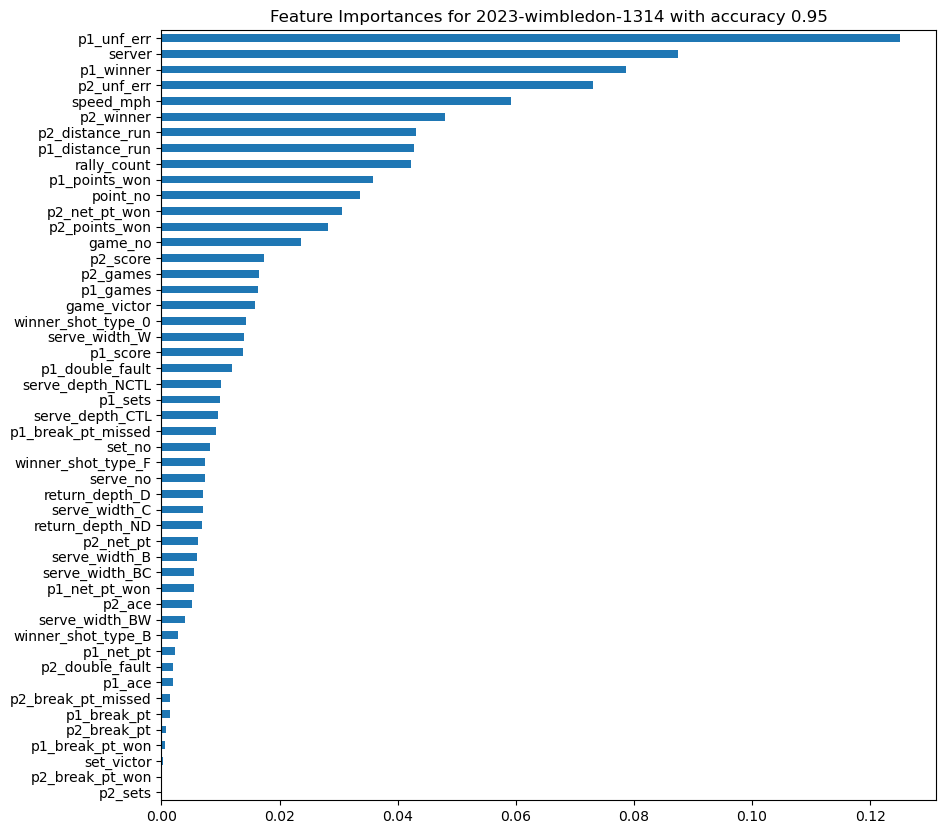

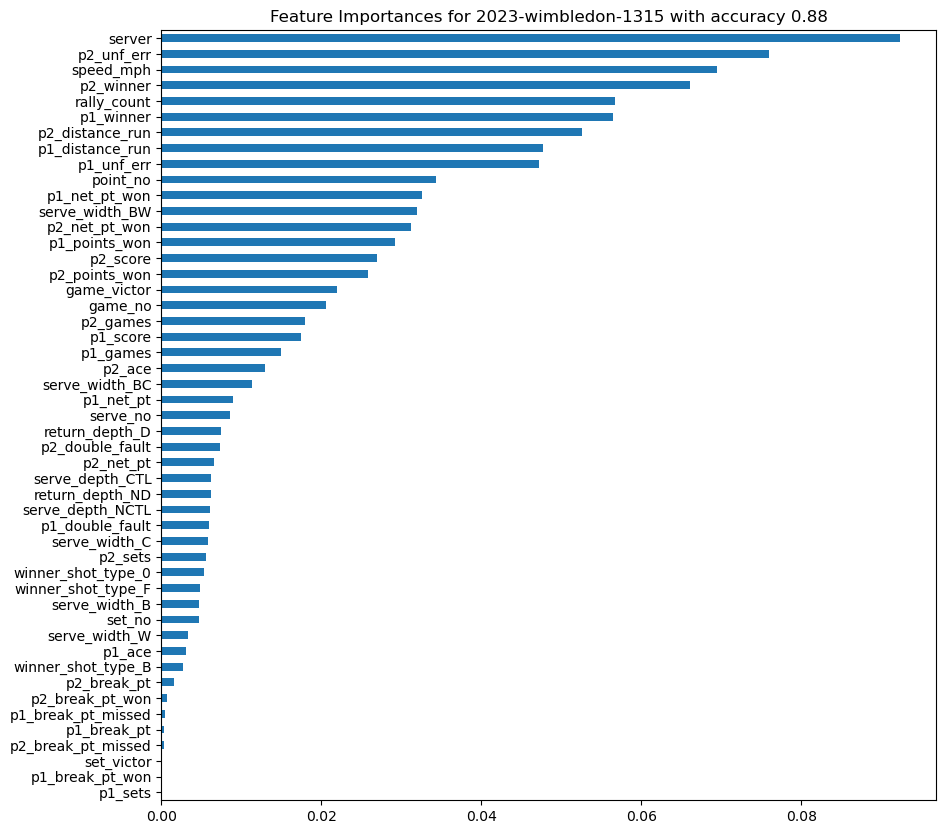

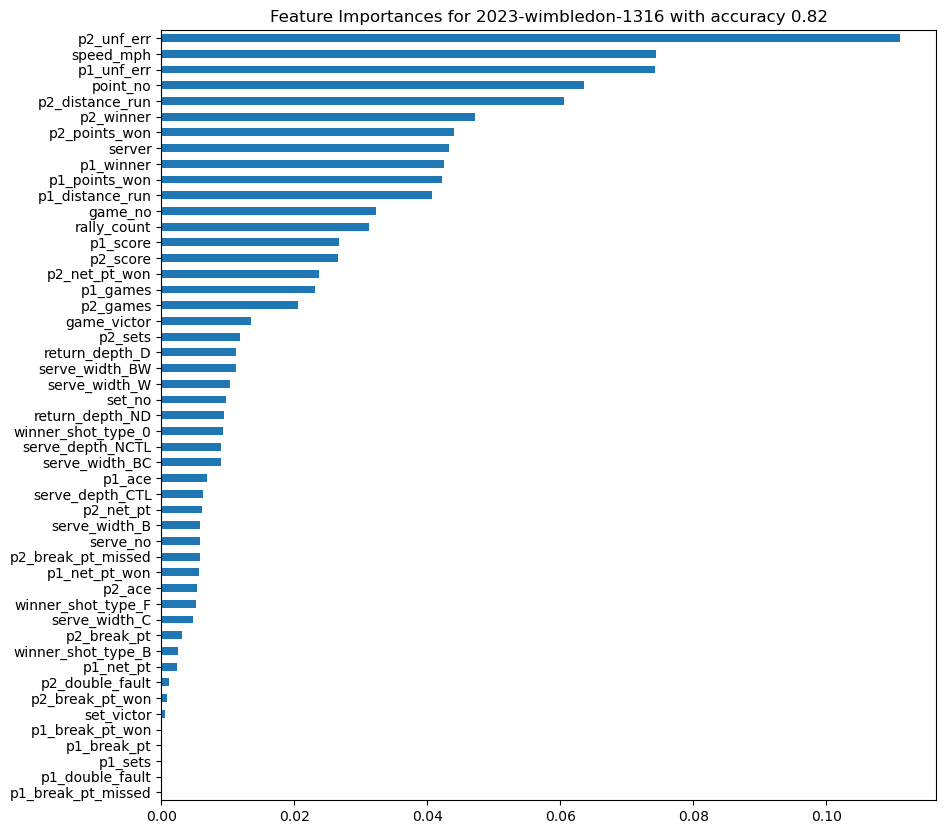

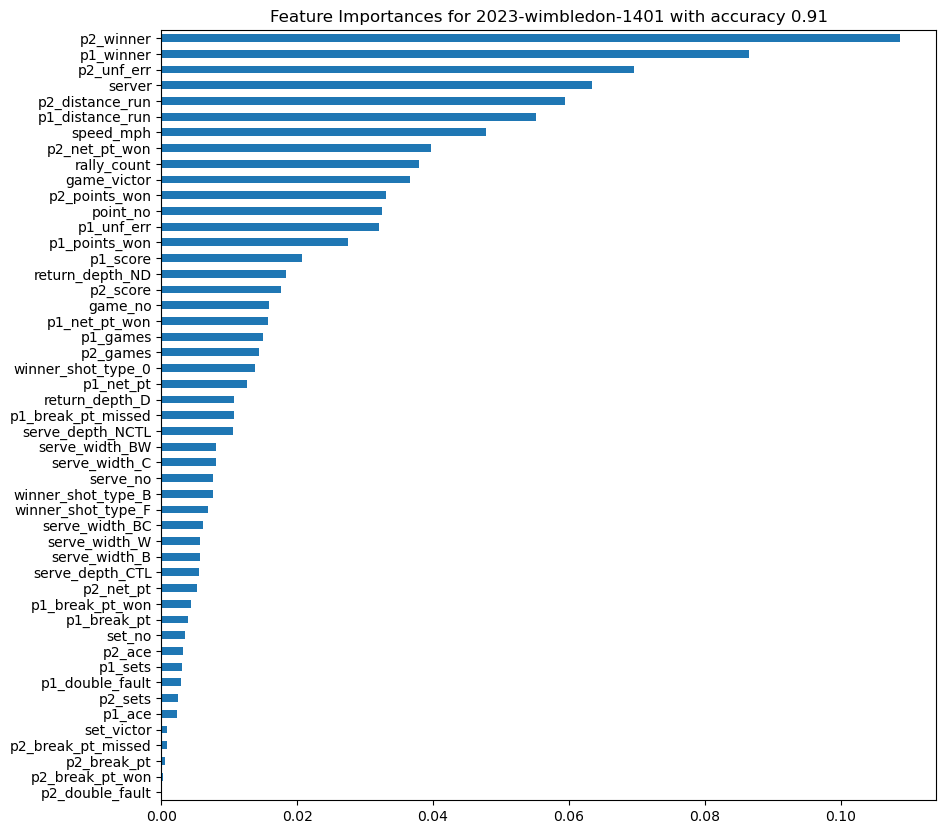

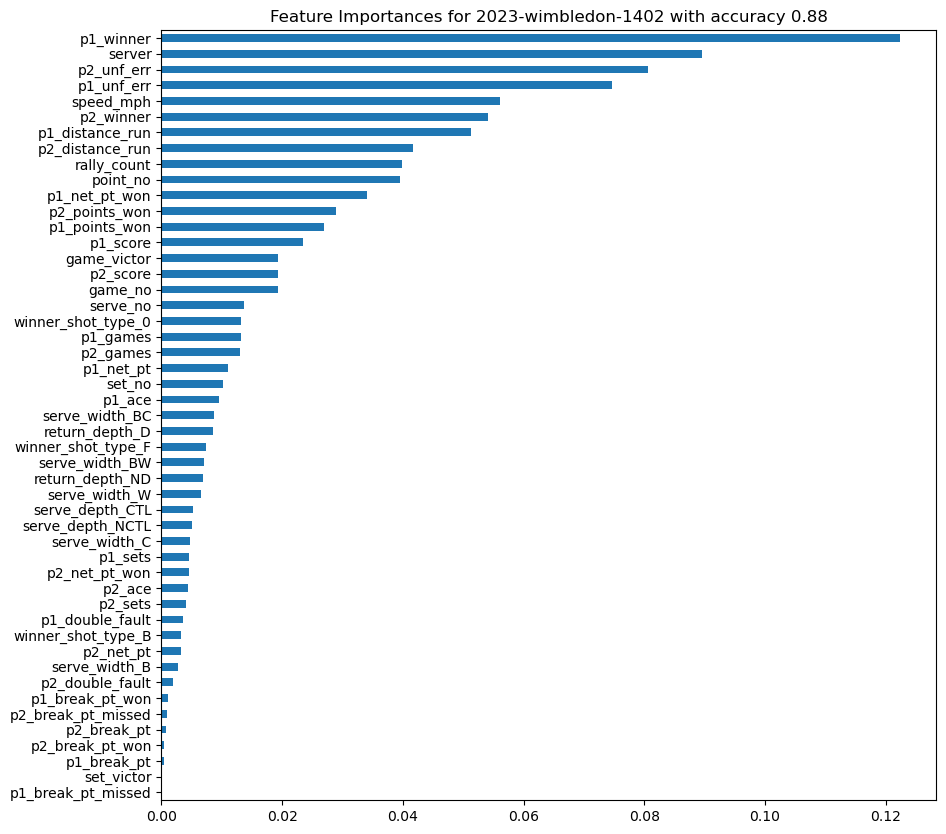

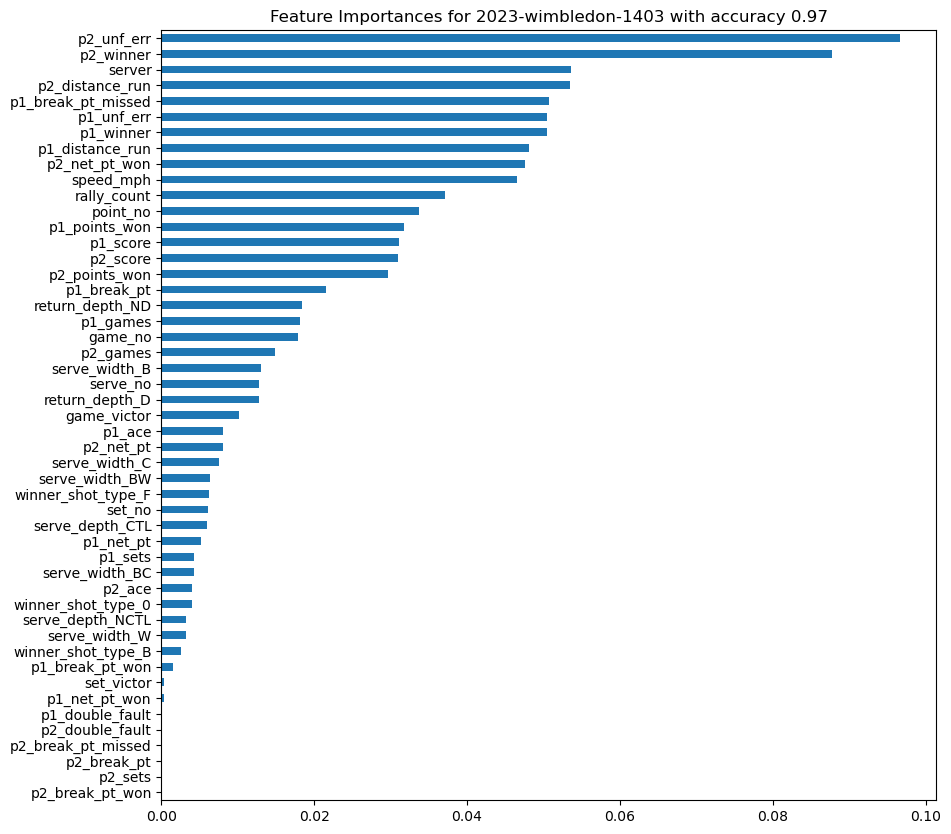

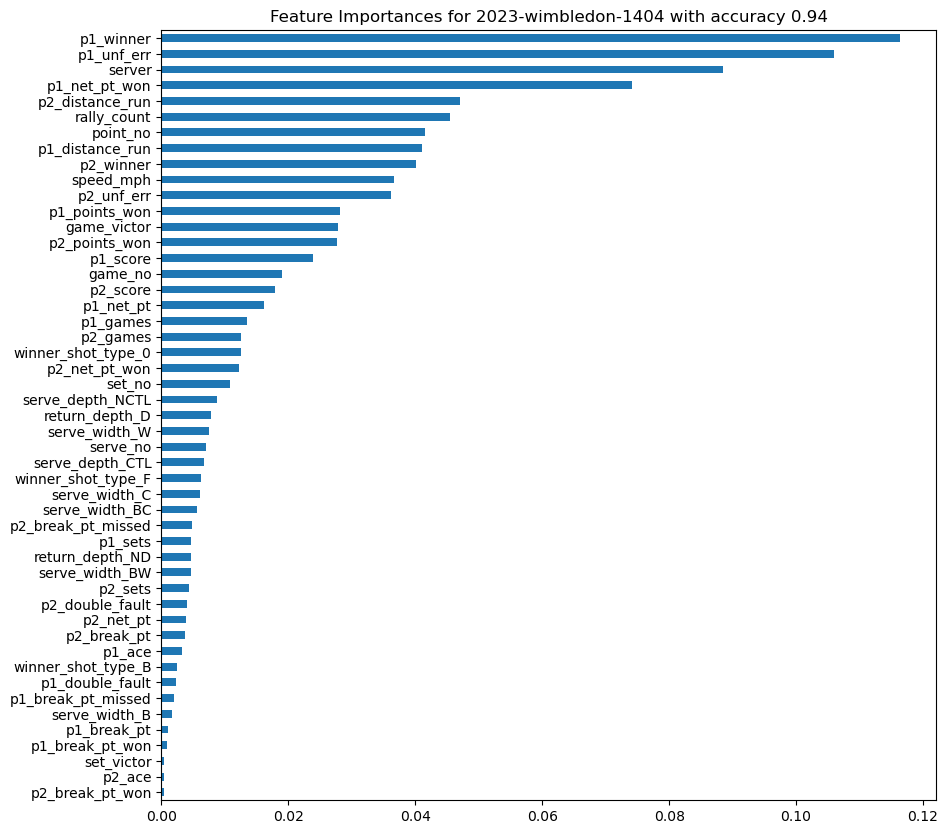

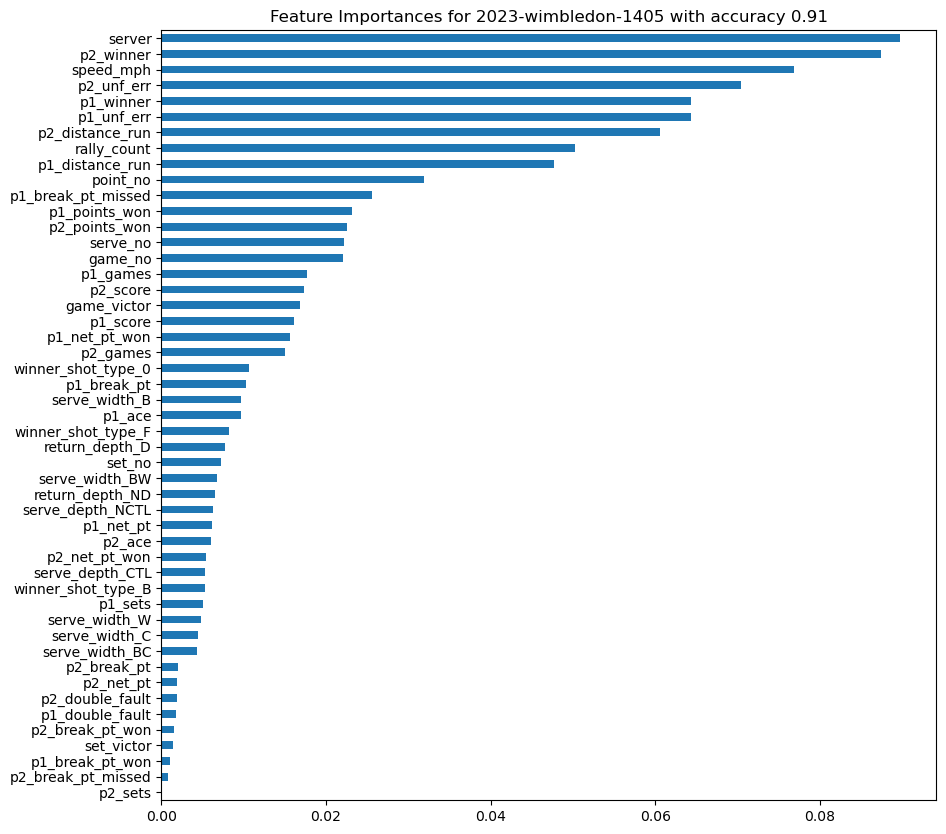

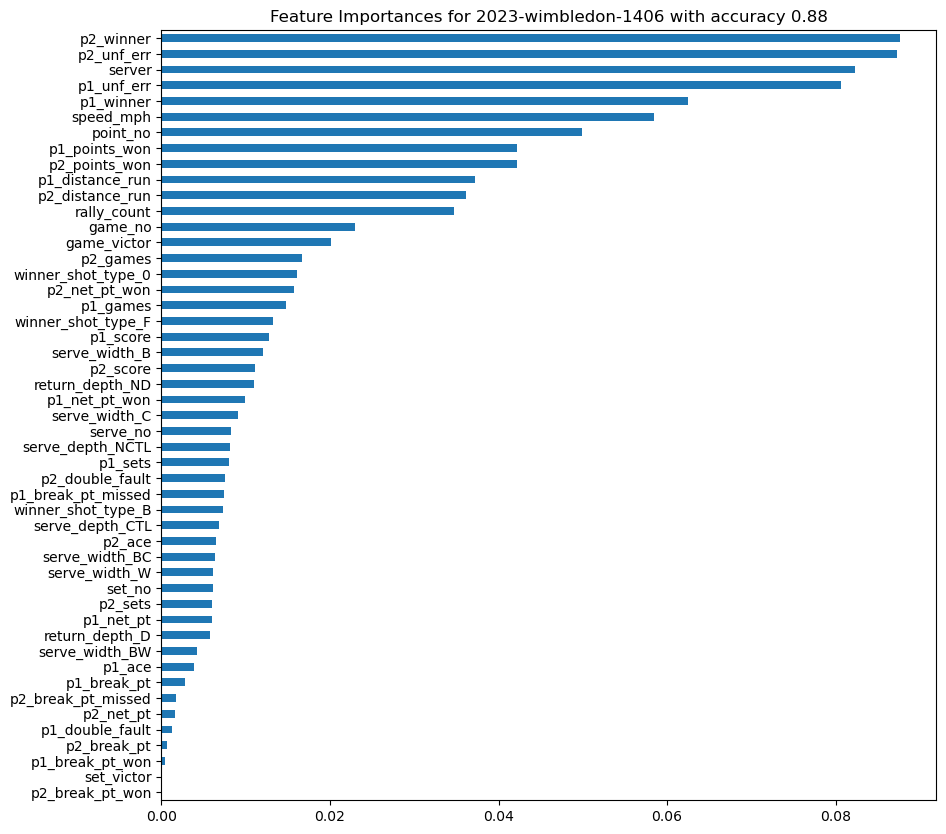

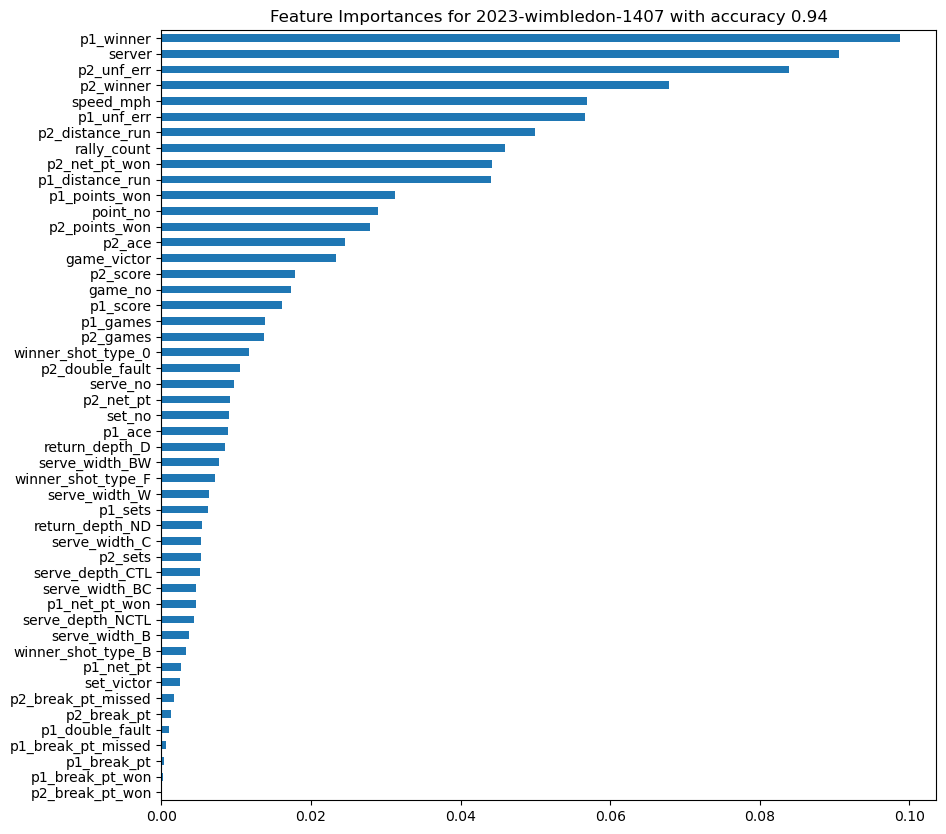

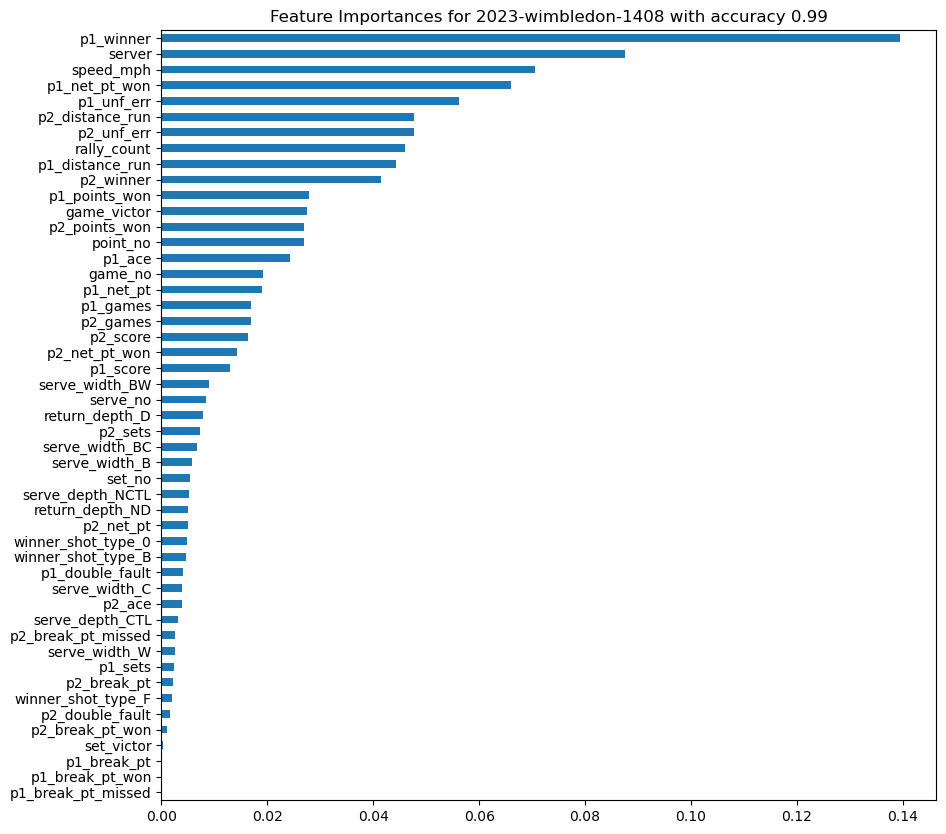

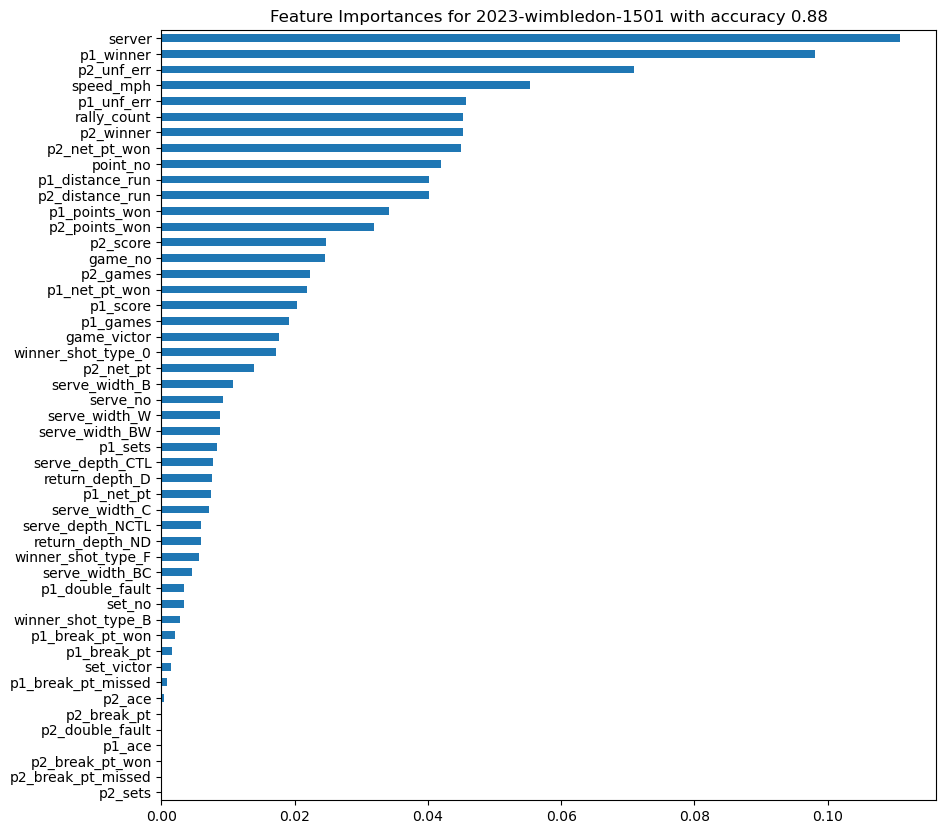

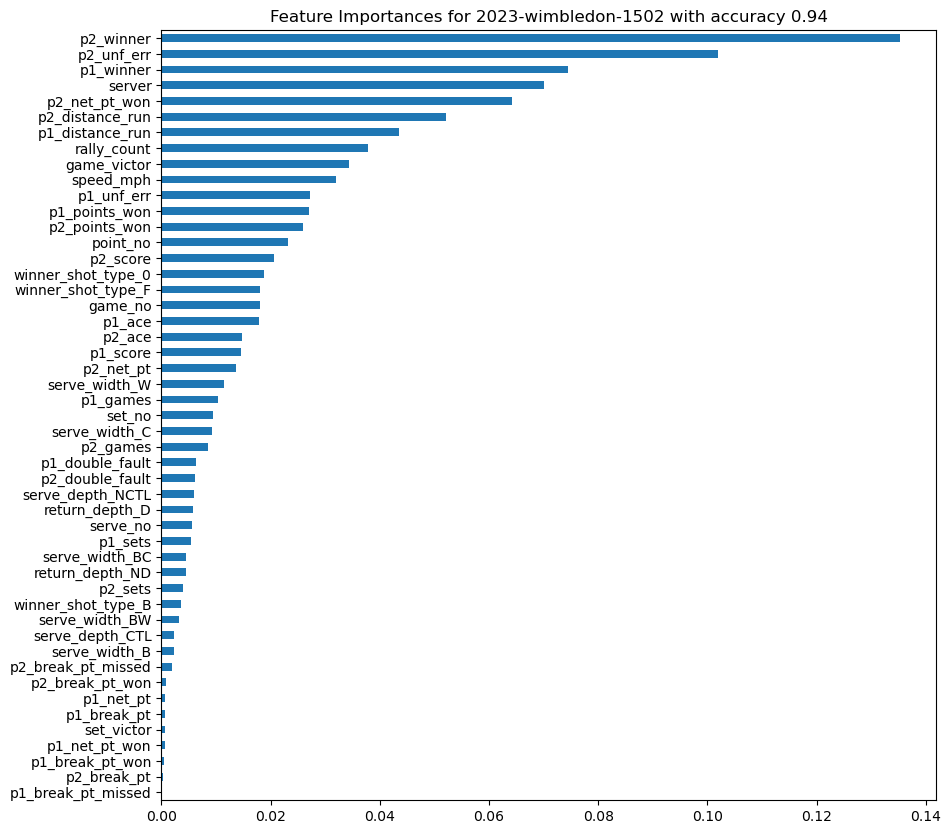

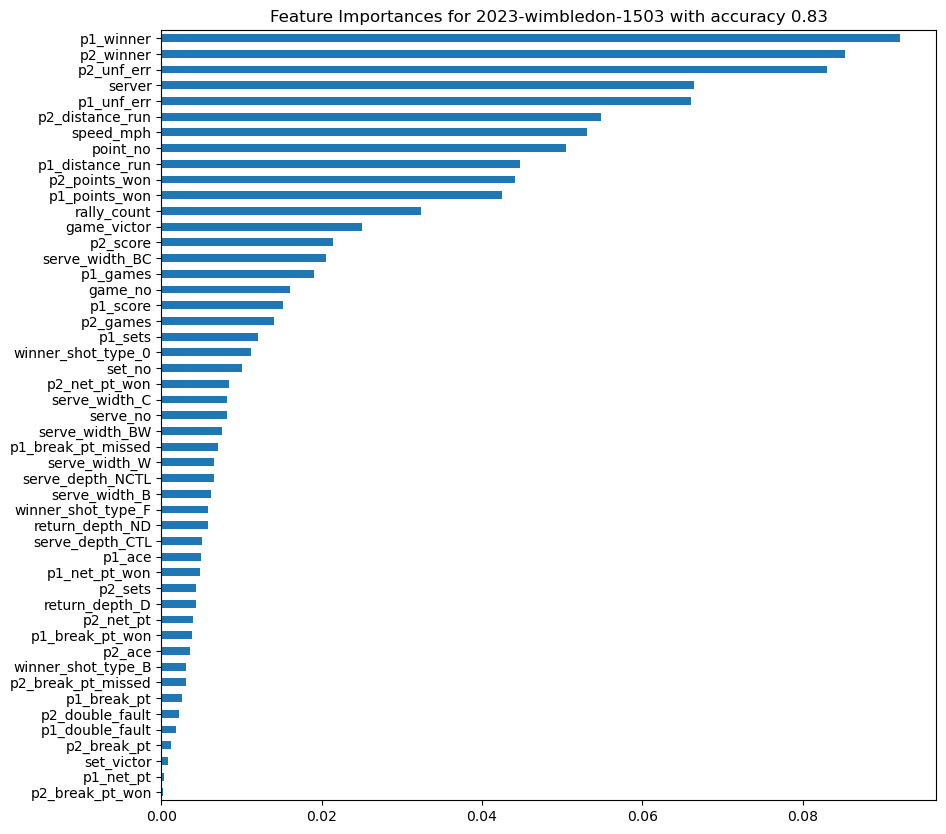

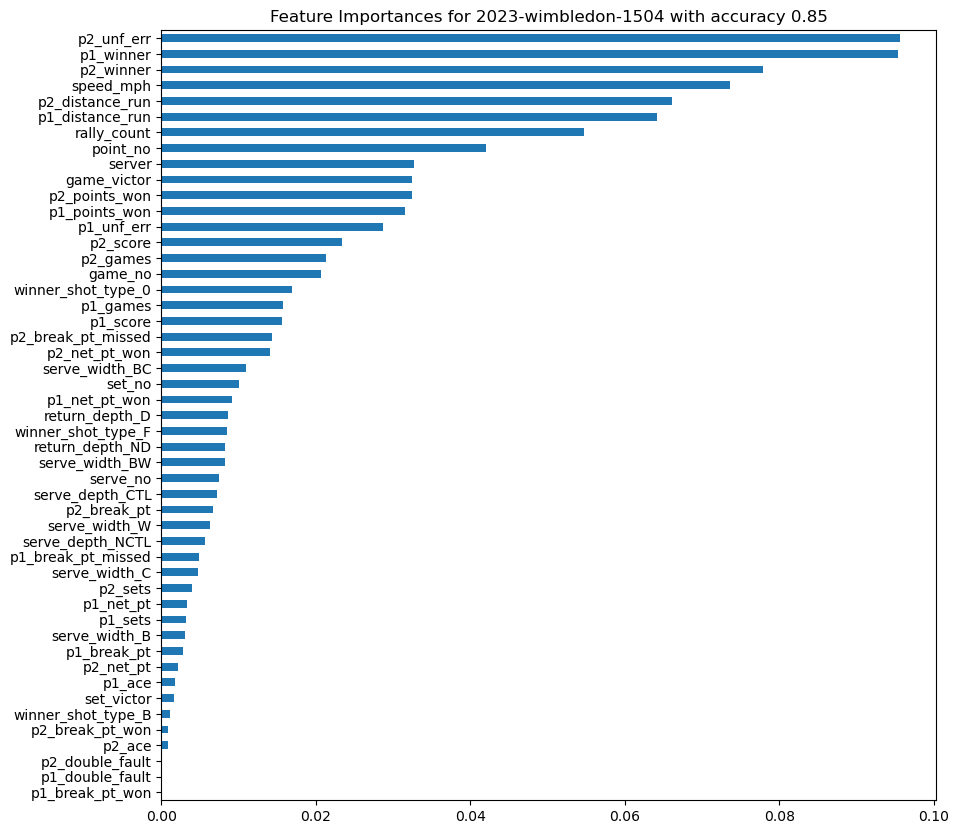

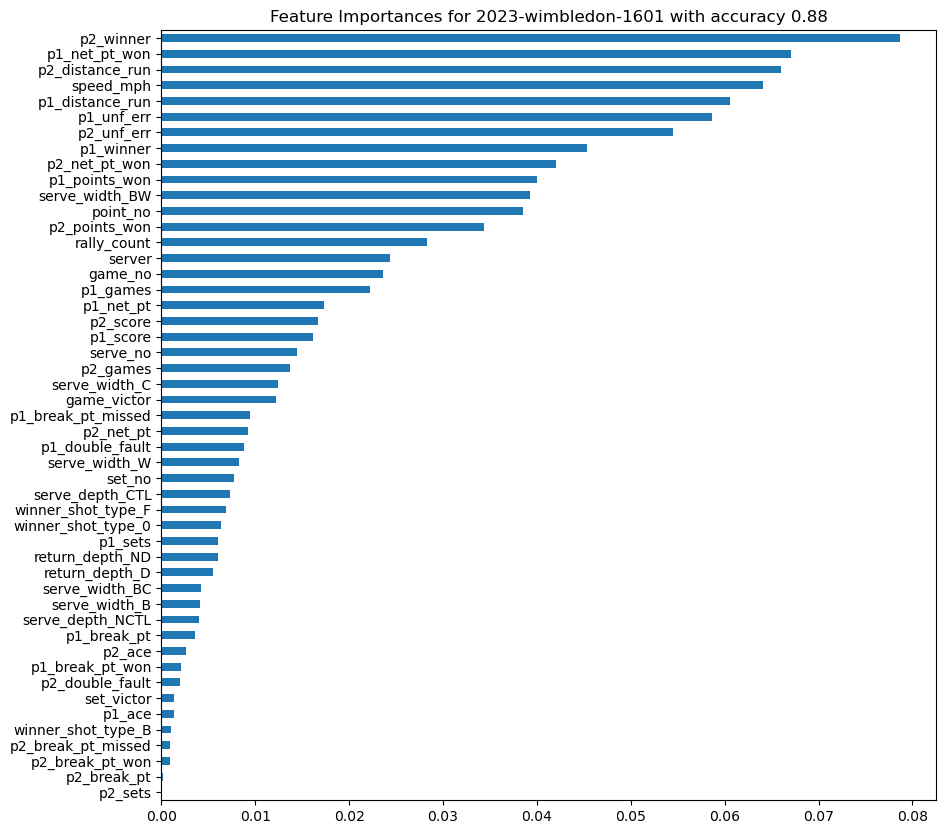

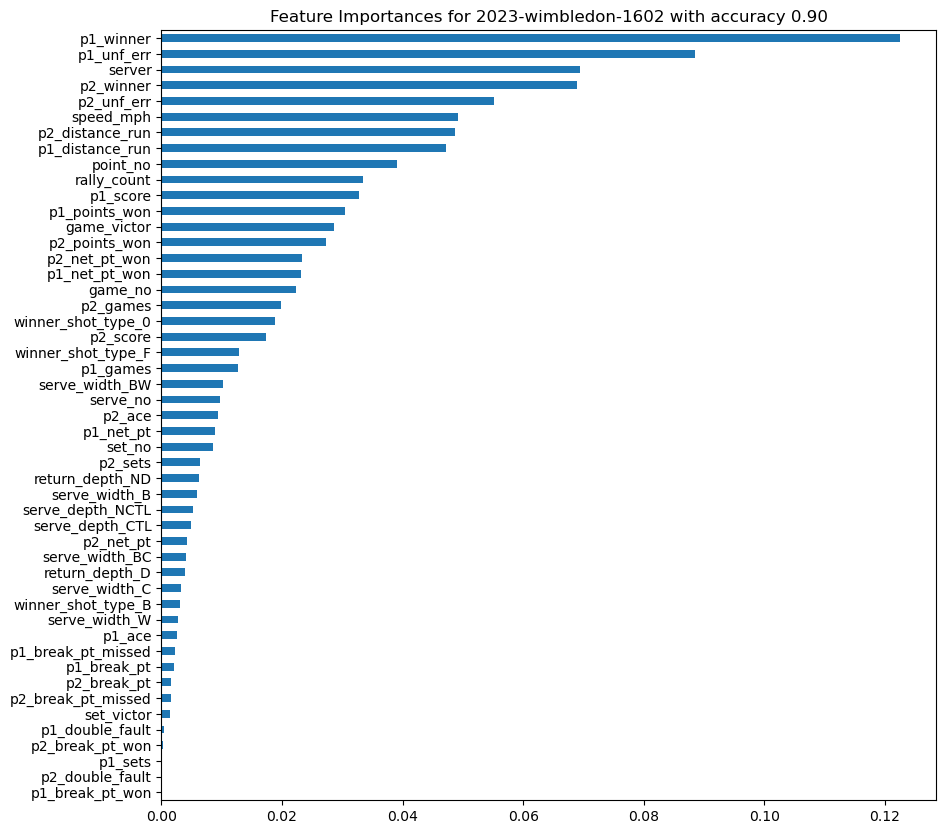

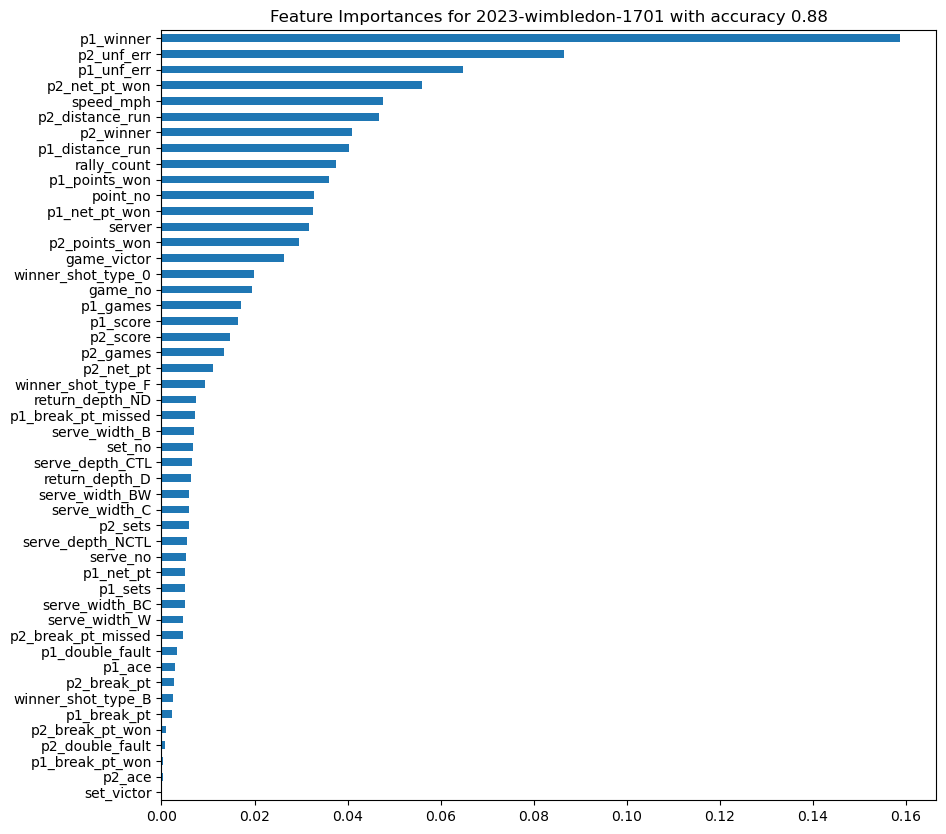

In [4]:
import matplotlib.pyplot as plt

for id in range(len(match)):
    # Create a new figure
    plt.figure(figsize=(10, 10))

    # Create a horizontal bar plot
    feature_importances[match[id]].sort_values().plot(kind='barh')

    # Set the title
    plt.title(f'Feature Importances for {match[id]} with accuracy {accuracy[match[id]]:.2f}')

    # Show the plot
    plt.show()